In [1]:
import tensorflow as tf
import cv2
import numpy as np
import scipy.io as sc
from glob import glob
import keras
from keras import layers

In [19]:
!unzip with_mask.zip;
!unzip without_mask.zip;

Archive:  with_mask.zip
   creating: with_mask/
  inflating: with_mask/augmented_image_218.jpg  
   creating: __MACOSX/
   creating: __MACOSX/with_mask/
  inflating: __MACOSX/with_mask/._augmented_image_218.jpg  
  inflating: with_mask/augmented_image_19.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_19.jpg  
  inflating: with_mask/augmented_image_31.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_31.jpg  
  inflating: with_mask/augmented_image_25.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_25.jpg  
  inflating: with_mask/augmented_image_230.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_230.jpg  
  inflating: with_mask/419-with-mask.jpg  
  inflating: __MACOSX/with_mask/._419-with-mask.jpg  
  inflating: with_mask/330-with-mask.jpg  
  inflating: __MACOSX/with_mask/._330-with-mask.jpg  
  inflating: with_mask/260-with-mask.jpg  
  inflating: __MACOSX/with_mask/._260-with-mask.jpg  
  inflating: with_mask/27-with-mask.jpg  
  inflating: __MACOSX/wi

  inflating: with_mask/293-with-mask.jpg  
  inflating: __MACOSX/with_mask/._293-with-mask.jpg  
  inflating: with_mask/457-with-mask.jpg  
  inflating: __MACOSX/with_mask/._457-with-mask.jpg  
  inflating: with_mask/122-with-mask.jpg  
  inflating: __MACOSX/with_mask/._122-with-mask.jpg  
  inflating: with_mask/augmented_image_223.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_223.jpg  
  inflating: with_mask/augmented_image_36.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_36.jpg  
  inflating: with_mask/augmented_image_22.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_22.jpg  
  inflating: with_mask/augmented_image_237.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_237.jpg  
  inflating: with_mask/augmented_image_34.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_34.jpg  
  inflating: with_mask/augmented_image_221.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_221.jpg  
  inflating: with_mask/augmented_image_235.jpg  
  inflating:

  inflating: with_mask/augmented_image_51.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_51.jpg  
  inflating: with_mask/111-with-mask.jpg  
  inflating: __MACOSX/with_mask/._111-with-mask.jpg  
  inflating: with_mask/464-with-mask.jpg  
  inflating: __MACOSX/with_mask/._464-with-mask.jpg  
  inflating: with_mask/augmented_image_86.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_86.jpg  
  inflating: with_mask/augmented_image_287.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_287.jpg  
  inflating: with_mask/augmented_image_92.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_92.jpg  
  inflating: with_mask/106-with-mask.jpg  
  inflating: __MACOSX/with_mask/._106-with-mask.jpg  
  inflating: with_mask/473-with-mask.jpg  
  inflating: __MACOSX/with_mask/._473-with-mask.jpg  
  inflating: with_mask/augmented_image_126.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_126.jpg  
  inflating: with_mask/augmented_image_132.jpg  
  inflating: __MACOSX/wi

  inflating: __MACOSX/with_mask/._279-with-mask.jpg  
  inflating: with_mask/83-with-mask.jpg  
  inflating: __MACOSX/with_mask/._83-with-mask.jpg  
  inflating: with_mask/394-with-mask.jpg  
  inflating: __MACOSX/with_mask/._394-with-mask.jpg  
  inflating: with_mask/175-with-mask.jpg  
  inflating: __MACOSX/with_mask/._175-with-mask.jpg  
  inflating: with_mask/400-with-mask.jpg  
  inflating: __MACOSX/with_mask/._400-with-mask.jpg  
  inflating: with_mask/augmented_image_134.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_134.jpg  
  inflating: with_mask/augmented_image_120.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_120.jpg  
  inflating: with_mask/augmented_image_108.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_108.jpg  
  inflating: with_mask/10-with-mask.jpg  
  inflating: __MACOSX/with_mask/._10-with-mask.jpg  
  inflating: with_mask/307-with-mask.jpg  
  inflating: __MACOSX/with_mask/._307-with-mask.jpg  
  inflating: with_mask/257-with-mask.jpg 

  inflating: with_mask/386-with-mask.jpg  
  inflating: __MACOSX/with_mask/._386-with-mask.jpg  
  inflating: with_mask/167-with-mask.jpg  
  inflating: __MACOSX/with_mask/._167-with-mask.jpg  
  inflating: with_mask/augmented_image_107.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_107.jpg  
  inflating: with_mask/augmented_image_113.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_113.jpg  
  inflating: with_mask/augmented_image_305.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_305.jpg  
  inflating: with_mask/augmented_image_311.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_311.jpg  
  inflating: with_mask/86-with-mask.jpg  
  inflating: __MACOSX/with_mask/._86-with-mask.jpg  
  inflating: with_mask/391-with-mask.jpg  
  inflating: __MACOSX/with_mask/._391-with-mask.jpg  
  inflating: with_mask/170-with-mask.jpg  
  inflating: __MACOSX/with_mask/._170-with-mask.jpg  
  inflating: with_mask/405-with-mask.jpg  
  inflating: __MACOSX/with_mask/._405-

  inflating: __MACOSX/with_mask/._augmented_image_288.jpg  
  inflating: with_mask/0-with-mask.jpg  
  inflating: __MACOSX/with_mask/._0-with-mask.jpg  
  inflating: with_mask/187-with-mask.jpg  
  inflating: __MACOSX/with_mask/._187-with-mask.jpg  
  inflating: with_mask/71-with-mask.jpg  
  inflating: __MACOSX/with_mask/._71-with-mask.jpg  
  inflating: with_mask/366-with-mask.jpg  
  inflating: __MACOSX/with_mask/._366-with-mask.jpg  
  inflating: with_mask/236-with-mask.jpg  
  inflating: __MACOSX/with_mask/._236-with-mask.jpg  
  inflating: with_mask/114-with-mask.jpg  
  inflating: __MACOSX/with_mask/._114-with-mask.jpg  
  inflating: with_mask/461-with-mask.jpg  
  inflating: __MACOSX/with_mask/._461-with-mask.jpg  
  inflating: with_mask/augmented_image_115.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_115.jpg  
  inflating: with_mask/augmented_image_101.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_101.jpg  
  inflating: with_mask/augmented_image_129.jpg  


  inflating: with_mask/augmented_image_189.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_189.jpg  
  inflating: with_mask/52-with-mask.jpg  
  inflating: __MACOSX/with_mask/._52-with-mask.jpg  
  inflating: with_mask/345-with-mask.jpg  
  inflating: __MACOSX/with_mask/._345-with-mask.jpg  
  inflating: with_mask/215-with-mask.jpg  
  inflating: __MACOSX/with_mask/._215-with-mask.jpg  
  inflating: with_mask/119-with-mask.jpg  
  inflating: __MACOSX/with_mask/._119-with-mask.jpg  
  inflating: with_mask/228-with-mask.jpg  
  inflating: __MACOSX/with_mask/._228-with-mask.jpg  
  inflating: with_mask/378-with-mask.jpg  
  inflating: __MACOSX/with_mask/._378-with-mask.jpg  
  inflating: with_mask/295-with-mask.jpg  
  inflating: __MACOSX/with_mask/._295-with-mask.jpg  
  inflating: with_mask/124-with-mask.jpg  
  inflating: __MACOSX/with_mask/._124-with-mask.jpg  
  inflating: with_mask/451-with-mask.jpg  
  inflating: __MACOSX/with_mask/._451-with-mask.jpg  
  inflating: with_ma

  inflating: without_mask/augmented_image_169.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_169.jpg  
  inflating: without_mask/augmented_image_155.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_155.jpg  
  inflating: without_mask/augmented_image_4.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_4.jpg  
  inflating: without_mask/augmented_image_141.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_141.jpg  
  inflating: without_mask/367.jpg    
  inflating: __MACOSX/without_mask/._367.jpg  
  inflating: without_mask/401.jpg    
  inflating: __MACOSX/without_mask/._401.jpg  
  inflating: without_mask/415.jpg    
  inflating: __MACOSX/without_mask/._415.jpg  
  inflating: without_mask/373.jpg    
  inflating: __MACOSX/without_mask/._373.jpg  
  inflating: without_mask/398.jpg    
  inflating: __MACOSX/without_mask/._398.jpg  
  inflating: without_mask/159.jpg    
  inflating: __MACOSX/without_mask/._159.jpg  
  inflating: without_mask/171.jpg 

  inflating: without_mask/augmented_image_286.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_286.jpg  
  inflating: without_mask/augmented_image_93.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_93.jpg  
  inflating: without_mask/117.jpg    
  inflating: __MACOSX/without_mask/._117.jpg  
  inflating: without_mask/augmented_image_87.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_87.jpg  
  inflating: without_mask/augmented_image_292.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_292.jpg  
  inflating: without_mask/augmented_image_245.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_245.jpg  
  inflating: without_mask/augmented_image_50.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_50.jpg  
  inflating: without_mask/augmented_image_44.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_44.jpg  
  inflating: without_mask/augmented_image_251.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_251.jpg  
  i

  inflating: without_mask/280.jpg    
  inflating: __MACOSX/without_mask/._280.jpg  
  inflating: without_mask/augmented_image_105.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_105.jpg  
  inflating: without_mask/augmented_image_111.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_111.jpg  
  inflating: without_mask/294.jpg    
  inflating: __MACOSX/without_mask/._294.jpg  
  inflating: without_mask/augmented_image_139.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_139.jpg  
  inflating: without_mask/337.jpg    
  inflating: __MACOSX/without_mask/._337.jpg  
  inflating: without_mask/451.jpg    
  inflating: __MACOSX/without_mask/._451.jpg  
  inflating: without_mask/445.jpg    
  inflating: __MACOSX/without_mask/._445.jpg  
  inflating: without_mask/323.jpg    
  inflating: __MACOSX/without_mask/._323.jpg  
  inflating: without_mask/135.jpg    
  inflating: __MACOSX/without_mask/._135.jpg  
  inflating: without_mask/109.jpg    
  inflating: __MACOSX/

  inflating: without_mask/19.jpg     
  inflating: __MACOSX/without_mask/._19.jpg  
  inflating: without_mask/augmented_image_262.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_262.jpg  
  inflating: without_mask/augmented_image_77.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_77.jpg  
  inflating: without_mask/augmented_image_239.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_239.jpg  
  inflating: without_mask/42.jpg     
  inflating: __MACOSX/without_mask/._42.jpg  
  inflating: without_mask/4.jpg      
  inflating: __MACOSX/without_mask/._4.jpg  
  inflating: without_mask/augmented_image_38.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_38.jpg  
  inflating: without_mask/56.jpg     
  inflating: __MACOSX/without_mask/._56.jpg  
  inflating: without_mask/augmented_image_205.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_205.jpg  
  inflating: without_mask/180.jpg    
  inflating: __MACOSX/without_mask/._180.jpg  
  inflati

  inflating: __MACOSX/without_mask/._augmented_image_14.jpg  
  inflating: without_mask/augmented_image_201.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_201.jpg  


In [20]:
!mkdir train;
!mv with_mask train;
!mv without_mask train;

### Set Up Data

In [21]:
from sklearn.model_selection import train_test_split
with_mask = glob('train/with_mask/*.jpg')
without_mask = glob('train/without_mask/*.jpg')
with_mask_train, with_mask_test = train_test_split(with_mask, test_size=0.1)
without_mask_train, without_mask_test = train_test_split(without_mask, test_size=0.1)


#moves the validation files out of the train directory and over to the val directory.

!mkdir val

!mkdir val/with_mask
files = ' '.join(with_mask_test)
!mv $files val/with_mask 

!mkdir val/without_mask
files = ' '.join(without_mask_test)
!mv $files val/without_mask

!rm -rf train/.ipynb_checkpoints
!rm -rf val/.ipynb_checkpoints


Found 1238 files belonging to 2 classes.
Found 138 files belonging to 2 classes.


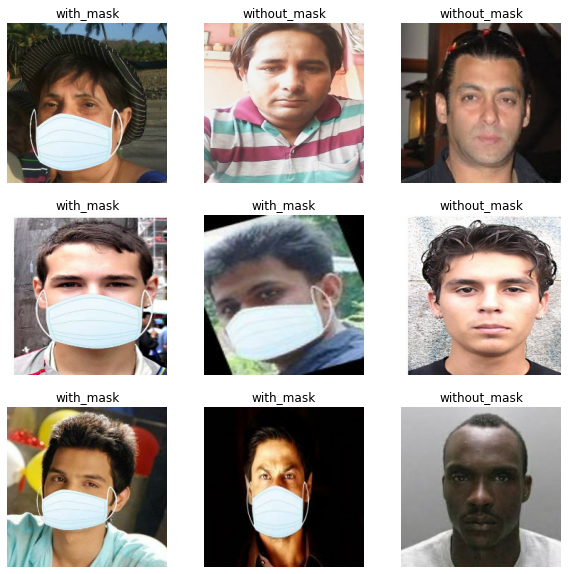

In [22]:
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory('./train', #sets up training dataset
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory('./val', #sets up validation dataset
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10)) 
for images, labels in train_dataset.take(1): #shows 9 examples of the training dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Augment data for training

In [23]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( #allow for rotation, zooming, and flipping of training images 
    rescale = 1./255.,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(#### 
    rescale = 1./255.,
#     rotation_range=90,
#     zoom_range=[1,2],
#     horizontal_flip=True,
#     fill_mode='nearest' 
)

train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    './val',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 1238 images belonging to 2 classes.
Found 138 images belonging to 2 classes.


### Modify network

In [25]:
model = keras.applications.MobileNetV2() #pre-trained, 14MB, smallest available model
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [26]:
#creates base model from pretrained network trained on ImageNet dataset
#Here by setting include_top to false we exclude the classification layers at the end of the network
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [184]:
from keras import Model
from keras import layers
base_model.trainable = False #freeze the base weights, model has already learned these

# # Flatten the output layer to 1 dimension
# x = layers.Flatten()(base_model.output)

# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = layers.Dense(512, activation='relu')(x)

# # Add a dropout rate of 0.5
# x = layers.Dropout(0.5)(x)

# # Add a final sigmoid layer for classification
# x = layers.Dense(2, activation='sigmoid')(x)

# new_model = tf.keras.models.Model(base_model.input, x)

# flat_layer = keras.layers.Flatten()(base_model.output)
# x = layers.GlobalAveragePooling2D(name='avg_pool')(base_model.output) # This layer is used to downsample the features
# flat_layer = keras.layers.Flatten()(x)
# # x = layers.Dropout(0.4)(flat_layer)                            # This layer is used to enforce feature redundancy 
# dense_layer = keras.layers.Dense(2, activation='softmax')(x) #binary output
# # final_output = layers.Activation('sigmoid')(dense_layer)
# new_model = keras.Model(inputs = base_model.input, outputs = dense_layer)

flat_layer = keras.layers.Flatten()(base_model.output)
dense_layer = keras.layers.Dense(2)(flat_layer) 
final_output = layers.Activation('softmax')(dense_layer)
new_model = keras.Model(inputs = base_model.input, outputs = final_output)

In [185]:
new_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

In [191]:
# EPOCHS = 5
# BATCH_SIZE = 10
# STEPS_PER_EPOCH = 5
# VALIDATION_STEPS = 1
EPOCHS = 8
BATCH_SIZE = 11
STEPS_PER_EPOCH = 5
VALIDATION_STEPS = 1
# MODEL_FILE = 'filename.model'

# history = new_model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     validation_data=validation_generator,
#     validation_steps=VALIDATION_STEPS)

MODEL_FILE = 'maskdetector.model'

hist = new_model.fit(train_generator, validation_data = validation_generator, validation_steps=1, steps_per_epoch = 5, epochs = 15)
# hist = model.fit(train_generator,epochs=5,validation_data=validation_generator)
new_model.save(MODEL_FILE)

Epoch 1/15
5/5 [==============================] - 3s 699ms/step - loss: 0.1141 - acc: 0.9625 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 2/15
5/5 [==============================] - 3s 690ms/step - loss: 0.2335 - acc: 0.9062 - val_loss: 0.0094 - val_acc: 1.0000
Epoch 3/15
5/5 [==============================] - 3s 661ms/step - loss: 0.0958 - acc: 0.9438 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 4/15
5/5 [==============================] - 3s 649ms/step - loss: 0.1508 - acc: 0.9375 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 5/15
5/5 [==============================] - 3s 693ms/step - loss: 0.1212 - acc: 0.9500 - val_loss: 0.0463 - val_acc: 1.0000
Epoch 6/15
5/5 [==============================] - 3s 648ms/step - loss: 0.1006 - acc: 0.9625 - val_loss: 0.1288 - val_acc: 0.9688
Epoch 7/15
5/5 [==============================] - 4s 716ms/step - loss: 0.0714 - acc: 0.9625 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 8/15
5/5 [==============================] - 3s 671ms/step - loss: 0.0700 - acc: 0.97

[0.9963955  0.00360446]


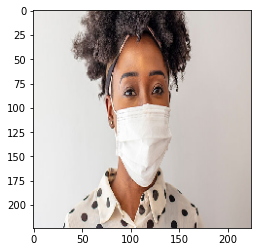

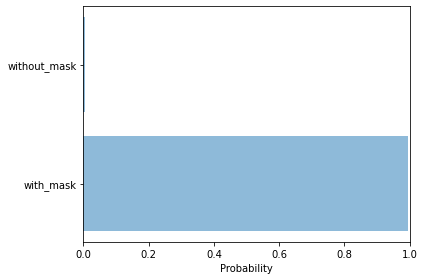

In [193]:
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input

def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

# We plot the original image
plt.figure()
img = image.load_img('./testWith/test2.jpg', target_size=(224, 224))
preds = predict(load_model(MODEL_FILE), img)
print(preds)
plt.imshow(img)

# We can visualize the predicted likelihood of each class
plt.figure()
labels = ["with_mask", "without_mask"]
plt.barh(range(2),preds,alpha=0.5)
plt.yticks(range(2),labels)
plt.xlabel('Probability')
plt.xlim(0,1)
plt.tight_layout()
plt.show()